In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from barebones_ai.unsupervised.fuzzy_kmeans import FuzzyKmeans
%matplotlib inline

# Feature Engineering Using Clustering Methods

In [5]:
iris = datasets.load_iris()

In [6]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Putting the data into a nice dataframe

In [8]:
df = pd.DataFrame({"SepalLength":iris.data[:,0],"SepalWidth":iris.data[:,1],"PetalLength":iris.data[:,2],"PetalWidth":iris.data[:,3],"FlowerClass":iris.target})

In [9]:
df.head(5)

,SepalLength,SepalWidth,PetalLength,PetalWidth,FlowerClass
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
X = df[["PetalLength","PetalWidth","SepalLength","SepalWidth"]]

First thing: pairwise scatter plot

Seems like the features are very linear related.

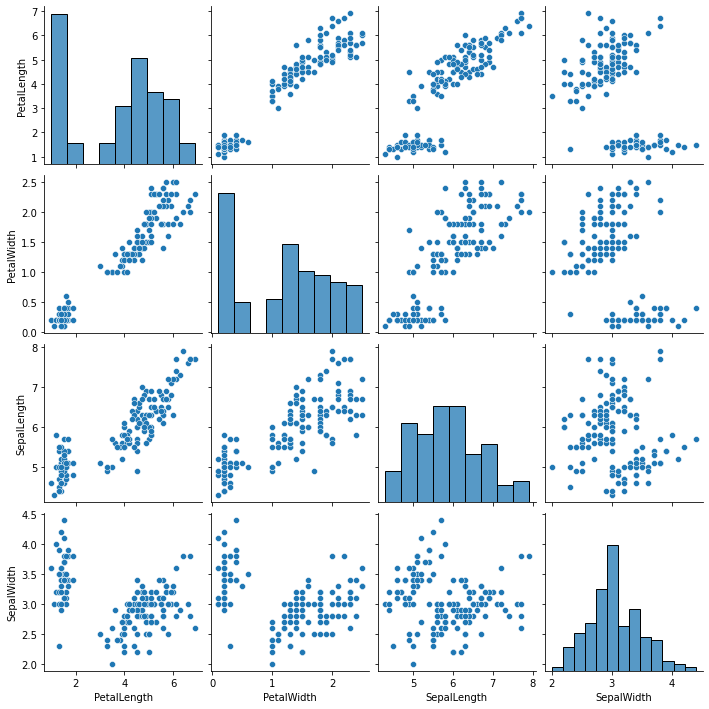

In [11]:
sns.pairplot(X)

/tmp/ipykernel_54766/539058912.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sert['PetalLength'].dropna().values,kde=False, color="blue")
/tmp/ipykernel_54766/539058912.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(veris['PetalLength'].dropna().values,kde=False, color="red")
/tmp/ipy

<AxesSubplot:title={'center':'SepalWidth'}>

<Figure size 432x288 with 0 Axes>

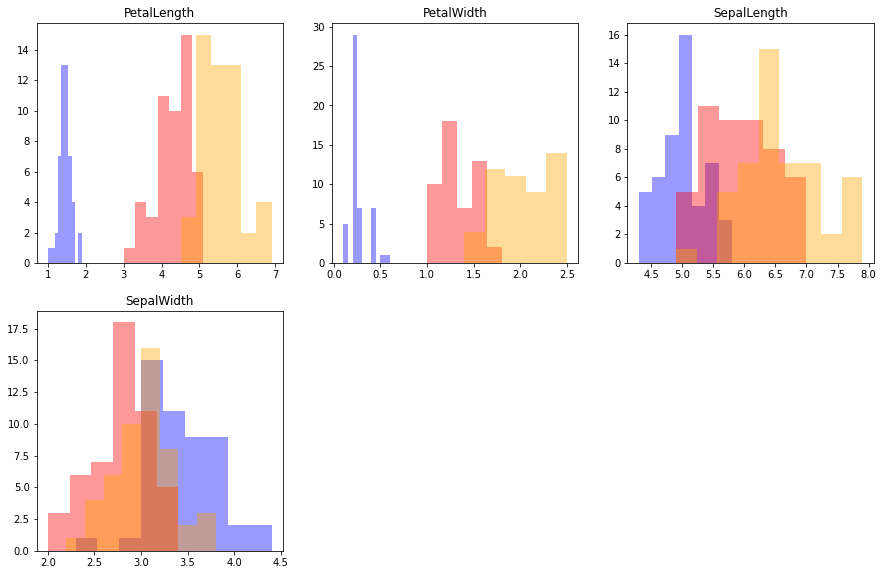

In [12]:
sert = df[df["FlowerClass"] == 0]
veris = df[df["FlowerClass"] == 1]
virg = df[df["FlowerClass"] == 2]
fig = plt.figure()
plt.figure(figsize=[15,15])
ax = plt.subplot(331)
ax.set_title("PetalLength")
sns.distplot(sert['PetalLength'].dropna().values,kde=False, color="blue")
sns.distplot(veris['PetalLength'].dropna().values,kde=False, color="red")
sns.distplot(virg['PetalLength'].dropna().values,kde=False, color="orange")
ax = plt.subplot(332)
ax.set_title("PetalWidth")
sns.distplot(sert['PetalWidth'].dropna().values,kde=False, color="blue")
sns.distplot(veris['PetalWidth'].dropna().values,kde=False, color="red")
sns.distplot(virg['PetalWidth'].dropna().values,kde=False, color="orange")
ax = plt.subplot(333)
ax.set_title("SepalLength")
sns.distplot(sert['SepalLength'].dropna().values,kde=False, color="blue")
sns.distplot(veris['SepalLength'].dropna().values,kde=False, color="red")
sns.distplot(virg['SepalLength'].dropna().values,kde=False, color="orange")
ax = plt.subplot(334)
ax.set_title("SepalWidth")
sns.distplot(sert['SepalWidth'].dropna().values,kde=False, color="blue")
sns.distplot(veris['SepalWidth'].dropna().values,kde=False, color="red")
sns.distplot(virg['SepalWidth'].dropna().values,kde=False, color="orange")

# sns.distplot(sert['PetalLength'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
#             axlabel='Age')

In [13]:
X = iris.data

SepalWidth and SepalLength seem to overlap for all the classes, so they arent great features for us to cluster.. The PetalLength and PetalWidth for each class seem to have clear different ranges in values.

## Fuzzy Kmeans to cluster based on Petal Width/Length

I thought it'd be pretty fun to make this from scratch. 
Referenced https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/cmeans.html
FuzzyKmeans object commented out because I imported it from another folder in my repo:
https://github.com/shyamsn97/Artificial-Intelligence/blob/master/ai_resources/Unsupervised%20Learning/FuzzyKmeans.py

In [14]:
class FuzzyKmeans():
    """
    Fuzzy Kmeans calculates cluster probabilities in regards to euclidian distance
    Equivalent to vanilla Kmeans if we assign a given point to the cluster with the highest probability
    """
    def __init__(self,X):
        self.X = X
        
    def calculate_centers(self,U,m):
        X = self.X
        ones = np.ones(X.shape[0]).reshape((X.shape[0],1))
        denom = (1/(U**m).dot(ones)).reshape(U.shape[0],)
        diagonal = np.diag(denom)
        centers = diagonal.dot((U**m).dot(X))
        return centers
        
    def calculate_fuzzy(self,centers,m):
        m = 2/(m-1)
        X = self.X
        us = np.ones(shape=(centers.shape[0],1))
        ones = np.ones(shape=(1,centers.shape[0]))
        for i in range(X.shape[0]):
            row = X[i].reshape(X.shape[1],1)
            row = row.dot(ones).T - centers
            norms = np.linalg.norm(row,2,axis=1).reshape(centers.shape[0],1)
            norms = (norms.dot(1/norms.T))**m
            sums = 1/np.sum(norms,axis=1).reshape(norms.shape[0],1)
            us = np.column_stack((us,sums))

        return us[:,1:]
        
    def predict(self,m,k,exit,seed,argmax=False): 
        """
        Main clustering function
        m is the degree of uncertainty, (fuzziness of cluster)
        k is the number of clusters
        exit is the exit criteria 
        set argmax = True for normal K-means
        """
        np.random.seed(seed)
        U = np.random.uniform(0,1,size=(k,X.shape[0])) #initialize cluster probabilities
        centers = self.calculate_centers(U,m)
        newcenters = 2*centers
        while np.linalg.norm((centers - newcenters),2) >= exit:
            newcenters = centers
            U = self.calculate_fuzzy(centers,m)
            centers = self.calculate_centers(U,m)
        if argmax:
            return np.argmax(U,axis=0).T
        return U.T

In [15]:
def standardize(X):
    '''
    z-score standardization, (x -mu)/std(x), standardizing the columns
    '''
    mu = np.mean(X,axis=0).reshape(X.shape[1],1)
    mumat = np.outer(mu,np.ones(X.shape[0])).T
    newx = X - mumat
    var = np.var(X,axis=0).reshape(X.shape[1],1)
    varmat = np.outer(mu,np.ones(X.shape[0])).T
    return newx*varmat

In [16]:
X = np.array(X)

In [25]:
class KMeans_Medians():
    
    def __init__(self,X):
        self.X = X
        self.center_assignments = {}
        self.centers = []
        
    def calculate_centers(self,dist=1):
        if dist == 1:
            self.centers = np.array(list(map(lambda x : np.mean(X[x,:],axis=0),self.center_assignments.values())))
        elif dist == 2:
            self.centers = np.array(list(map(lambda x : np.median(X[x,:],axis=0),self.center_assignments.values())))


    def predict(self,k,seed,exit=0.001,dist_type = "mean"):
        
        X = self.X
        self.centers = np.zeros(shape=(k,X.shape[1]))
        print(self.centers.shape)
        for i in range(k):
            for j in range(X.shape[1]):
                minx = np.min(X[:,j])
                maxx = np.max(X[:,j])
                self.centers[i,j] = np.random.uniform(minx,maxx)
        oldcenters = self.centers + 4
        while np.all(np.linalg.norm((self.centers - oldcenters),2) >= exit):
            oldcenters = self.centers
            for i in range(k):
                self.center_assignments[i] = []
            for i in range(X.shape[0]):
                ones = np.ones(oldcenters.shape[0]).reshape(oldcenters.shape[0],1)
                sample = ones.dot(X[i,:].reshape(1,X.shape[1]))
                closest = np.argmin(np.linalg.norm(oldcenters - sample,2,axis=1))
                self.center_assignments[closest].append(i)
                if dist_type == "mean":
                    self.calculate_centers(1)
                elif dist_type == "median":
                    self.calculate_centers(2)
                    
        end = np.zeros(X.shape[0])
        for i in range(k):
            end[self.center_assignments[i]] = i
        
        return end

In [26]:
fuzzy = FuzzyKmeans(X)

In [28]:
spectral = SpectralClustering(
        n_clusters=3, eigen_solver='arpack')

In [29]:
spectral.fit(X)

SpectralClustering(eigen_solver='arpack', n_clusters=3)

In [30]:
m = KMeans(n_clusters=3)

In [31]:
m.fit(X)

KMeans(n_clusters=3)

In [32]:
m.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1], dtype=int32)

We'll use three clusters for 3 classes, and use either the fuzzy probs or the maximum values(equivalent to just k-means)

Fuzzy probs:

In [37]:
fuzzy.fit(k=3)

In [40]:
fuzzy_clusters = fuzzy.predict(X)

Here we'll compare the predictive power of models that use all the features, just the fuzzy probabilities, and substituting petal length/width with the kmeans clusters

In [41]:
lr = LogisticRegression()

In [42]:
newd = np.array(df)

In [43]:
newd = newd[:,1:]

In [44]:
newd[:10,:]

array([[3.5, 1.4, 0.2, 0. ],
       [3. , 1.4, 0.2, 0. ],
       [3.2, 1.3, 0.2, 0. ],
       [3.1, 1.5, 0.2, 0. ],
       [3.6, 1.4, 0.2, 0. ],
       [3.9, 1.7, 0.4, 0. ],
       [3.4, 1.4, 0.3, 0. ],
       [3.4, 1.5, 0.2, 0. ],
       [2.9, 1.4, 0.2, 0. ],
       [3.1, 1.5, 0.1, 0. ]])

In [45]:
y = iris.target

Model with original features

A simple logistic regression model can achieve 95% accuracy

In [26]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),fuzzy_clusters,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.96

This is probably due to the fact that the 3 classes clearly have different value ranges for petal length & width so the cluster probs work very well in predicting flower class. Still pretty cool.

Model with just kmeans cluster values

In [27]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),kmeans_clusters,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

This is pretty cool. By just using the clusters we've reduced the rank of our data to 1 and still managed to achieve 94% accuracy 

Model with kmeans clusters in replacement of Petal Width/Length

In [28]:
newx = np.column_stack((kmeans_clusters,newd[:,2:]))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

adding sepal width/length doesn't seem to improve the accuracy

Model with fuzzy probs in addition to original variables

In [29]:
newx = np.column_stack((fuzzy_clusters,newd))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.9533333333333334

Seems we can't improve our accuracy by just adding the cluster probabilities 

Model with kmeans cluster vals in addition to original variables

In [33]:
newx = np.column_stack((kmeans_clusters,newd))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

Seems like adding features to the Kmeans model doesn't improve its accuracy

### From our results we can see that interestingly enough, the model with just the fuzzy cluster probabilities generated from performing fuzzy kmeans on Petal Length and Petal Width resulted in the best predictive model. This is pretty cool because this means that even though we reduced our data matrix to 3 dimensions we were able to capture enough of the trend to give accurate predictions. This is probably due to the fact that Petal Length/Width have very clearly separated ranges of values for each class, making it easy to cluster the classes together using them. That being said, the results were pretty unexpected and cool.